In [1]:
import keras
import numpy as np
from neuralStellar2 import stellarGrid,NNmodel
import pymc3 as pm
import theano.tensor as T
import corner
import pandas as pd
import theano
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('grid2_trun.csv')

In [3]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu'])
m1.loadModel('Ran_files/big_grid_77/000_best_model.h5')

Model: "neuralstellar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_78 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_79 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_80 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_81 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_82 (Dense)             (None, 128)             

In [4]:
M=np.array([0.8,1.0,1.2])
Age=np.array([8,6,4])
Feh=np.array([-0.05,0,0.05])
Y=np.array([0.27,0.28,0.29])
MLT=np.array([1.9,1.9,1.9])
print('R/Rsun', 'Teff', 'delta nu', '=')
y_out = 10**m1.model.predict(np.log10([M,Age,10**Feh,Y,MLT]).T).T
y_out[1] = y_out[1]*5000
[obsR, obsTeff, obsDelnu] = y_out
print(y_out)
obsL = (y_out[0])**2*(y_out[1]/5942.261537)**4
print('L/Lsun = '+str(obsL))
#1, 5777, 135

R/Rsun Teff delta nu =
[[7.6266861e-01 1.1611066e+00 1.4831970e+01]
 [5.0264365e+03 5.9541748e+03 4.0766277e+03]
 [1.9116266e+02 1.1378390e+02 3.1470616e+00]]
L/Lsun = [ 0.29778683  1.3590127  48.72982   ]


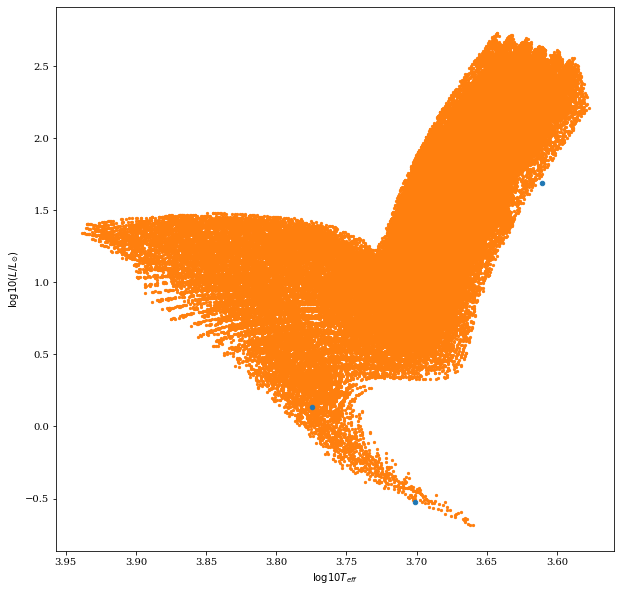

In [5]:
points = df[:100000]
fig, ax=plt.subplots(1,1, figsize=(10,10))
ax.scatter(np.log10(obsTeff), np.log10(obsL), s=20, zorder=10)
ax.scatter(np.log10(points['effective_T']),np.log10(points['luminosity']),s=5,zorder=1)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
plt.show()

In [13]:
model = pm.Model()
with model:
    '''
    M1 = pm.Deterministic('mass1',pm.Beta('a1',1.5,1.5)*(2*0.2)+(0.8-0.2))
    Age1 = pm.Deterministic('age1',pm.Beta('b1',1.5,1.5)*(2*0.5)+(8-0.5))
    feh1 = pm.Deterministic('feh1',pm.Beta('c1',1.1,1.1)*(2*0.1)+(-0.05-0.1))
    Y1 = pm.Deterministic('Y1',pm.Beta('d1',1.1,1.1)*(2*0.01)+(0.27-0.01))
    #MLT1 = pm.Deterministic('MLT1',pm.Beta('e1',1.1,1.1)*(2*0.1)+(1.9-0.1))
    
    M2 = pm.Deterministic('mass2',pm.Beta('a2',1.5,1.5)*(2*0.2)+(1.0-0.2))
    Age2 = pm.Deterministic('age2',pm.Beta('b2',1.5,1.5)*(2*0.5)+(6-0.5))
    feh2 = pm.Deterministic('feh2',pm.Beta('c2',1.1,1.1)*(2*0.1)+(0-0.1))
    Y2 = pm.Deterministic('Y2',pm.Beta('d2',1.1,1.1)*(2*0.01)+(0.28-0.01))
    #MLT2 = pm.Deterministic('MLT2',pm.Beta('e2',1.1,1.1)*(2*0.1)+(1.9-0.1))
    
    M3 = pm.Deterministic('mass3',pm.Beta('a3',1.5,1.5)*(2*0.2)+(1.2-0.2))
    Age3 = pm.Deterministic('age3',pm.Beta('b3',1.5,1.5)*(2*0.5)+(4-0.5))
    feh3 = pm.Deterministic('feh3',pm.Beta('c3',1.1,1.1)*(2*0.1)+(0.05-0.1))
    Y3 = pm.Deterministic('Y3',pm.Beta('d3',1.1,1.1)*(2*0.01)+(0.29-0.01))
    #MLT3 = pm.Deterministic('MLT3',pm.Beta('e3',1.1,1.1)*(2*0.1)+(1.9-0.1))
    '''
    
    M1 = pm.Normal('mass1',1.0,0.2)
    Age1 = pm.Bound(pm.Normal, lower=1.0, upper=12)('age1',6,1)
    feh1 = pm.Normal('feh1',0.0,0.1)
    Y1 = pm.Normal('Y1',0.28,0.01)

    M2 = pm.Normal('mass2',1.0,0.2)
    Age2 = pm.Bound(pm.Normal, lower=1.0, upper=12)('age2',6,1)
    feh2 = pm.Normal('feh2',0.0,0.1)
    Y2 = pm.Normal('Y2',0.28,0.01)

    M3 = pm.Normal('mass3',1.0,0.2)
    Age3 = pm.Bound(pm.Normal, lower=1.0, upper=12)('age3',6,1)
    feh3 = pm.Normal('feh3',0.0,0.1)
    Y3 = pm.Normal('Y3',0.28,0.01)

    M = T.stack(M1,M2,M3)
    Age = T.stack(Age1,Age2,Age3)
    feh = T.stack(feh1,feh2,feh3)
    Y = T.stack(Y1,Y2,Y3)
    MLT = T.stack(1.9,1.9,1.9)
    
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    #obs data from NN generated
    obs_L = pm.Normal('obs_L',(10**obs[0])**2*(10**obs[1]*5000/5942.261537)**4,0.1, observed=obsL)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1]*5000,70, observed=obsTeff)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],0.1, observed=obsDelnu)

In [18]:
trace = pm.load_trace(directory='pymc3_traces/3star', model=model)

In [19]:
pm.summary(trace, var_names=['mass1','age1','feh1','Y1','mass2','age2','feh2','Y2','mass3','age3','feh3','Y3'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mass1,0.786,0.001,0.785,0.787,0.000,0.000,6.0,6.0,6.0,13.0,2.10
age1,6.003,0.025,5.954,6.057,0.006,0.005,16.0,16.0,16.0,22.0,1.86
feh1,0.000,0.000,-0.000,0.000,0.000,0.000,8.0,5.0,18.0,33.0,2.22
Y1,0.280,0.000,0.279,0.281,0.000,0.000,13.0,13.0,13.0,14.0,1.95
mass2,0.998,0.004,0.988,1.003,0.002,0.002,3.0,3.0,3.0,11.0,2.41
age2,5.819,0.222,5.401,6.000,0.135,0.109,3.0,3.0,3.0,34.0,1.97
feh2,-0.018,0.019,-0.051,0.000,0.013,0.011,2.0,2.0,2.0,11.0,2.87
Y2,0.280,0.000,0.280,0.280,0.000,0.000,9.0,9.0,13.0,15.0,1.90
mass3,1.144,0.002,1.140,1.145,0.001,0.001,4.0,4.0,5.0,60.0,1.84
age3,6.299,0.303,6.019,6.761,0.208,0.174,2.0,2.0,2.0,18.0,2.69


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018A6E09F630>,
      dtype=object)

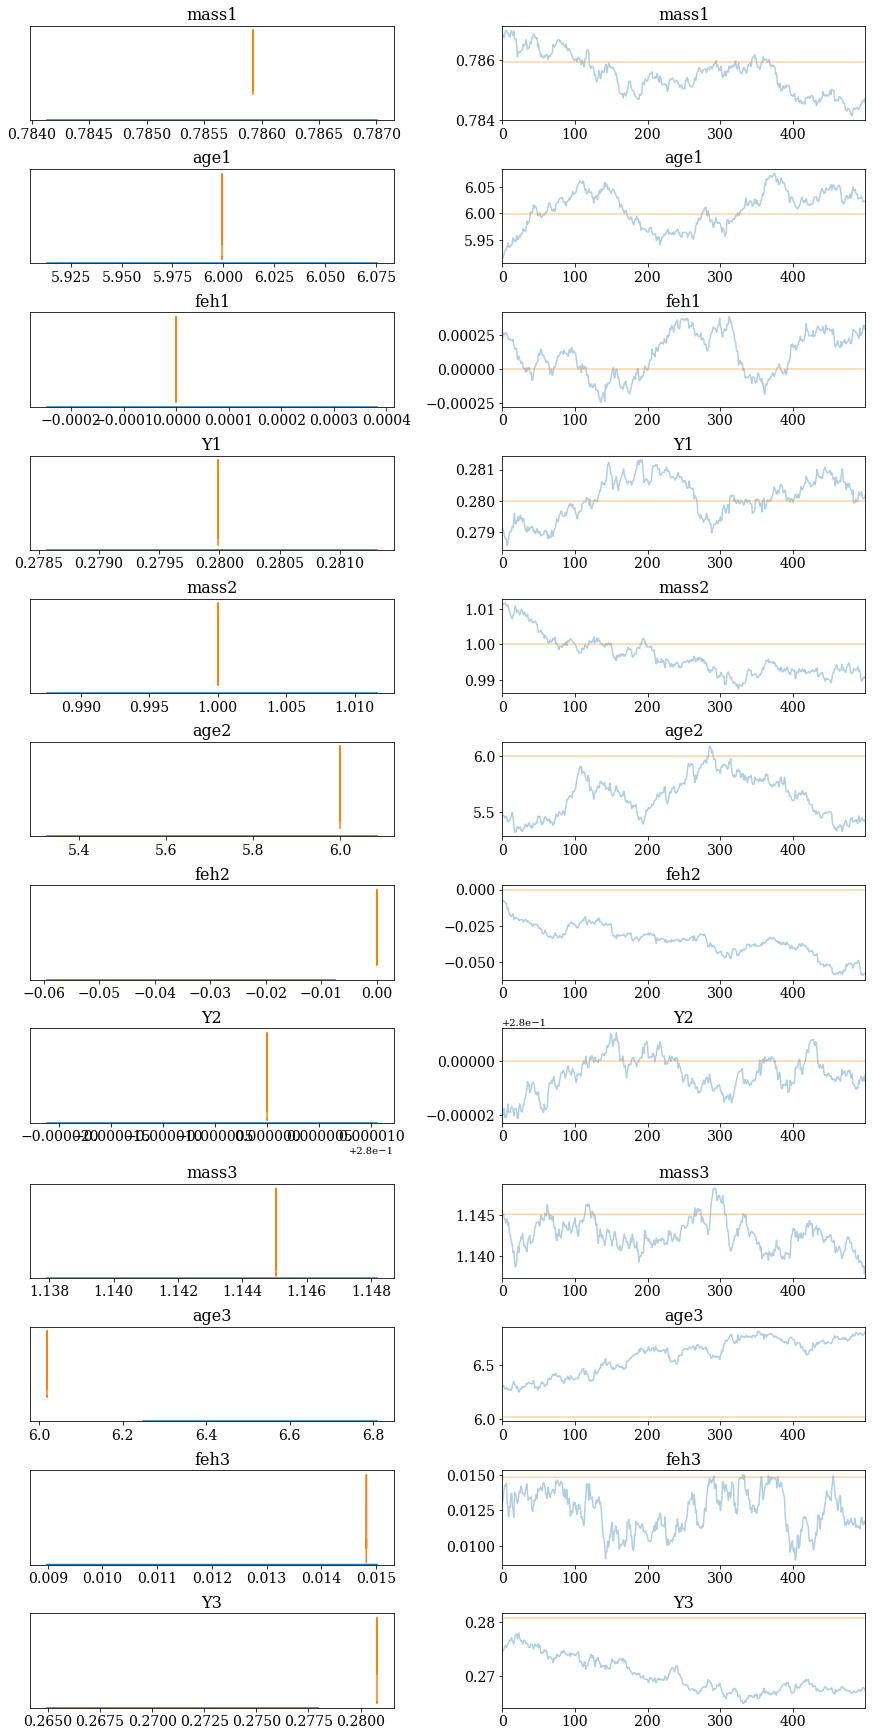

In [20]:
pm.plots.traceplot(trace, var_names=['mass1','age1','feh1','Y1','mass2','age2','feh2','Y2','mass3','age3','feh3','Y3'])

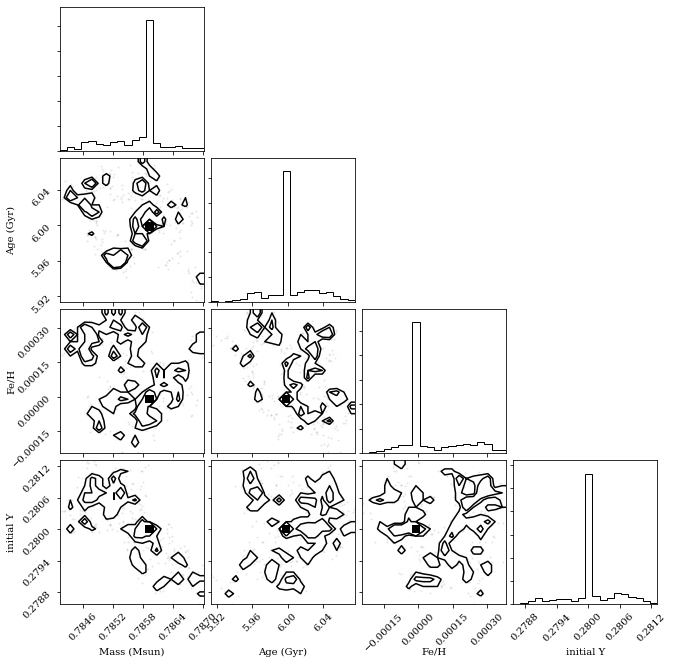

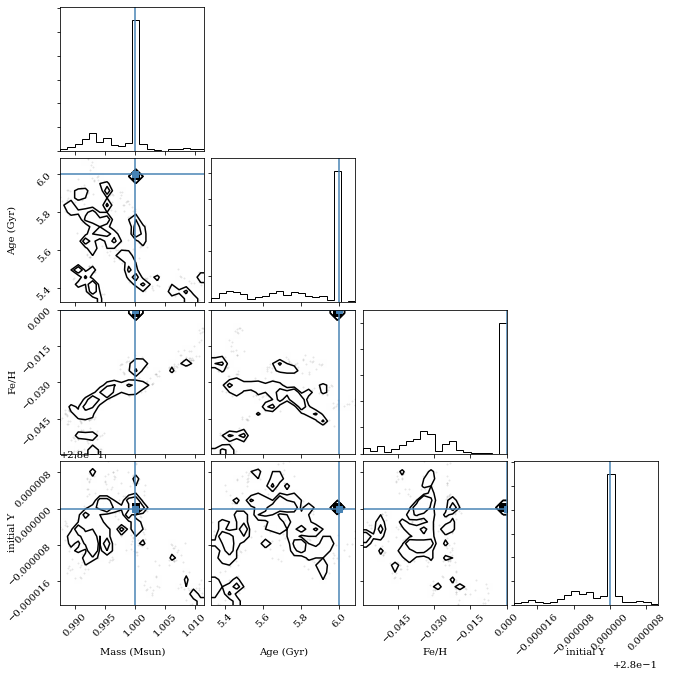

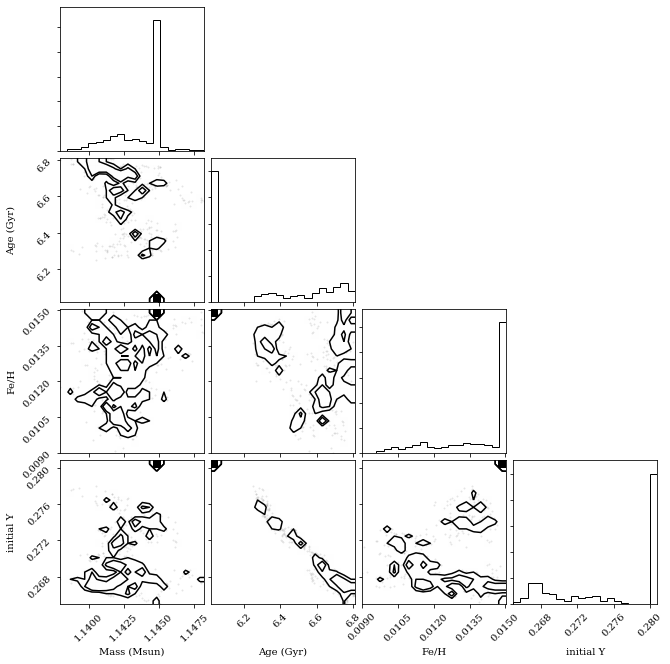

In [21]:
truths=[[0.8,8,-0.05,0.27],[1.0,6,0,0.28],[1.2,4,0.05,0.29]]
for i,num in enumerate([1,2,3]):
    corner.corner(np.array([trace['mass'+str(num)], trace['age'+str(num)], trace['feh'+str(num)], trace['Y'+str(num)]]).T, 
                  truths=truths[i], 
                  labels=['Mass (Msun)','Age (Gyr)','Fe/H','initial Y']);